In [78]:
##### Setup #####
# Imports
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import sqlite3, json, os
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import sparse
from sklearn.neighbors import kneighbors_graph
from scipy import linalg
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import pandas as pd
import json, os

kmeans = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/kmeans.csv'))
spectral = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/spectral.csv'))
agg = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/agglomerative.csv'))
merged = pd.merge(kmeans, agg, how='inner', on='mrn_csn_pair')

# Config file
with open('cfg.json') as json_file:
    cfg = json.load(json_file)

# Get ts freshed data
ts_freshed_dir = os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/complete_24h.csv')
dat = pd.read_csv(ts_freshed_dir)

# Train-test split
from sklearn.model_selection import train_test_split

dat, _ = train_test_split(dat, test_size=0.3, random_state=42)
dat = dat[dat['ischemic_stroke'] == 1]

# Get only hemodynamic measures
cols = dat.columns
cols_to_keep = []
lr_features = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/lr_features.csv'))
rf_features = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/rf_features.csv'))

thresh = 0
cols = lr_features[lr_features['Lasso Coefficient'].abs() >= thresh]['Feature'].tolist() + rf_features[rf_features['RF Score'].abs() >= thresh]['Feature'].tolist()

cols = dat.columns
measures_to_get = ['pulse', 'sbp', 'dbp', 'temp', 'pulse_ox']
for m in measures_to_get:
    p = [x for x in cols if m in x]
    cols_to_keep = cols_to_keep + p

print('# cols:',len(cols_to_keep))
dat = dat[['mrn_csn_pair'] + cols_to_keep]
dat_n = dat.drop(columns=['mrn_csn_pair'])
print(dat.shape)

# Get time series
def getTS(dat_conn):
    merged_dir = os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Merged.db')
    merged_conn = sqlite3.connect(merged_dir)
    dat_ts = pd.read_sql('SELECT * FROM timeseries_instantaneous WHERE timestamp >= 0 AND timestamp <= 1440',
                         merged_conn)
    dat_ts = pd.merge(dat_ts, dat_conn, how='inner', on='mrn_csn_pair')

    mrn_csns = dat_ts['mrn_csn_pair'].unique()
    time_indices = range(0, int(1440 / 5))
    n = len(mrn_csns)

    timeseries = np.empty((n, len(time_indices) + 1, len(measures_to_get)))
    for m, f in enumerate(measures_to_get):
        f_dat = dat_ts[dat_ts['measure'] == f]
        for mrn_csns_n, mcp in enumerate(mrn_csns):
            ts = pd.Series(np.NaN, index=time_indices)
            dat_sub = f_dat[f_dat['mrn_csn_pair'] == mcp].reset_index(drop=True)

            ts.loc[0] = dat_sub['value'][0]
            for i, r in dat_sub.iterrows():
                ts.loc[round(r['timestamp'] / 5)] = r['value']
            ts = ts.interpolate('pad')
            for ti, t in enumerate(ts):
                timeseries[mrn_csns_n, ti, m] = t
    return timeseries


# Silhouette
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
          'tab:olive', 'tab:cyan']


def getSilhouette(cluster):
    sil = silhouette_samples(dat_n, cluster)
    sil_avg = silhouette_score(dat_n, cluster)

    sildf = pd.DataFrame({'sil': sil, 'cluster': cluster})
    sildf.sort_values(['cluster', 'sil'], inplace=True)
    sildf.reset_index(drop=True, inplace=True)

    plt.bar(range(sildf.shape[0]), sildf['sil'], color=[colors[x] for x in sildf['cluster']])
    plt.axhline(sil_avg)
    plt.title('Silhouette')
    plt.xlabel('Samples')
    plt.ylabel('Silhouette coefficient')
    plt.show()


# Plot
def getTSplot(n_clusters, cluster):
    ncol = 2
    fig, ax = plt.subplots(math.ceil(len(measures_to_get) / ncol), ncol, figsize=(10, 10))
    for meas_i, meas in enumerate(measures_to_get):
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                  'tab:olive', 'tab:cyan']
        for i in range(n_clusters):
            mn = np.mean(timeseries[cluster == i, :-1, meas_i], axis=0)
            std = timeseries[cluster == i, :-1, meas_i].std(axis=0)
            ax[meas_i // ncol, meas_i % ncol].fill_between(range(len(std)), mn - 1 * std, mn + 1 * std, color=colors[i],
                                                           alpha=0.1)
            ax[meas_i // ncol, meas_i % ncol].plot(mn, color=colors[i])

        ax[meas_i // ncol, meas_i % ncol].set_title(meas)
        ax[meas_i // ncol, meas_i % ncol].set_xlabel('Time (min)')
    fig.tight_layout(pad=2)
    plt.show()


# cols: 772
(1148, 773)


In [79]:
pd.merge(dat,merged,how='inner', on='mrn_csn_pair').shape

(140, 775)

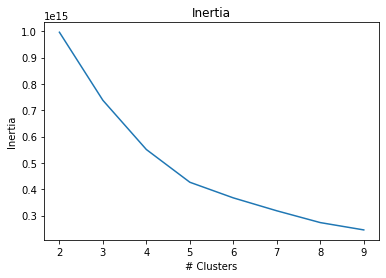

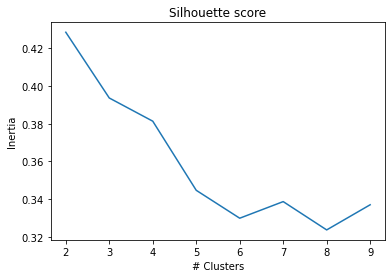

In [56]:
##### K-Means #####

# Elbow plot
ks = range(2, 10)
inertias = []
ss = []
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(dat_n)
    inertias.append(km.inertia_)
    ss.append(silhouette_score(dat_n, km.labels_))


plt.plot(ks, inertias)
plt.title('Inertia')
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.show()

plt.plot(ks, ss)
plt.title('Silhouette score')
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.show()

0    142
6    116
2     97
3     62
5     26
1     14
4      1
Name: cluster, dtype: int64


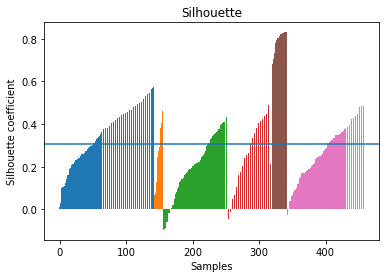

In [58]:
# Single
n_clusters = 7
km = KMeans(n_clusters=n_clusters)
km.fit(dat_n)
cluster = km.labels_

# Plot
dat_conn = pd.DataFrame.from_dict({'mrn_csn_pair': dat['mrn_csn_pair'].tolist(),
                                   'cluster': cluster})
print(dat_conn['cluster'].value_counts())
dat_conn[dat_conn['cluster']==2].to_csv('kmeans.csv',index=False)
# timeseries = getTS(dat_conn)
getSilhouette(cluster)
# getTSplot(n_clusters, cluster)

In [61]:
print(dat_conn[dat_conn['cluster']==5].shape)
pd.merge(dat_conn[dat_conn['cluster']==5], merged, how='inner', on='mrn_csn_pair').shape

(26, 2)


(24, 4)

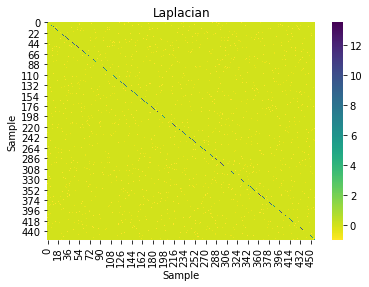

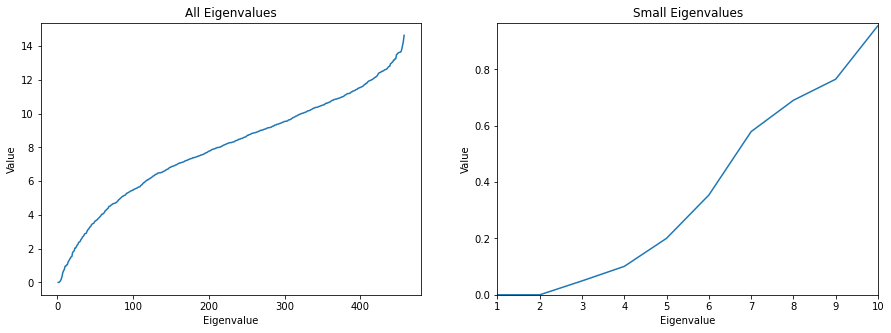

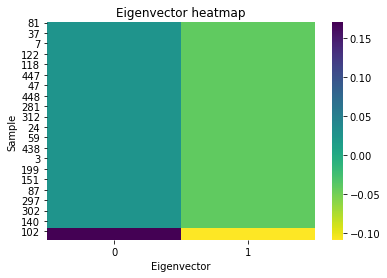

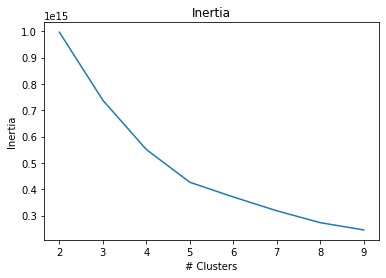

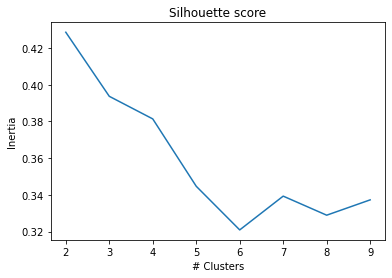

In [62]:
##### Spectral Clustering #####

# Get Laplacian via connectivity graph
connectivity = kneighbors_graph(X=dat_n, n_neighbors=8, mode='connectivity')
dist = (1 / 2) * (connectivity + connectivity.T)

L = sparse.csgraph.laplacian(csgraph=dist, normed=False).toarray()
sns.heatmap(L, cmap='viridis_r')
plt.title('Laplacian')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

# Get eigenvals/vecs
evals, evecs = linalg.eig(L)
evals = np.real(evals)
evecs = np.real(evecs)

evecs_norm = np.apply_along_axis(lambda v: np.linalg.norm(v, ord=2), axis=0, arr=evecs)
evals_sort_idxs = np.argsort(evals)
evals_sort = evals[evals_sort_idxs]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x=range(1, evals_sort_idxs.size + 1), y=evals_sort, ax=ax[0])
sns.lineplot(x=range(1, evals_sort_idxs.size + 1), y=evals_sort, ax=ax[1])

ax[0].set_title('All Eigenvalues')
ax[0].set_xlabel('Eigenvalue')
ax[0].set_ylabel('Value')
xmax = 10
ax[1].set_xlim(1, xmax)
ax[1].set_ylim(min(evals_sort), evals_sort[xmax])
ax[1].set_title('Small Eigenvalues')
ax[1].set_xlabel('Eigenvalue')
ax[1].set_ylabel('Value')
plt.show()

zero_evals_idx = np.argwhere(abs(evals) < 1e-5)
evals[zero_evals_idx]
proj_df = pd.DataFrame(evecs[:, zero_evals_idx.squeeze()])
sns.heatmap(proj_df.sort_values(by=[0]), cmap='viridis_r')
plt.title('Eigenvector heatmap')
plt.xlabel('Eigenvector')
plt.ylabel('Sample')
plt.show()

# Elbow plot
ks = range(2, 10)
inertias = []
ss = []
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(dat_n)
    inertias.append(km.inertia_)
    ss.append(silhouette_score(dat_n, km.labels_))

plt.plot(ks, inertias)
plt.title('Inertia')
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.show()

plt.plot(ks, ss)
plt.title('Silhouette score')
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.show()

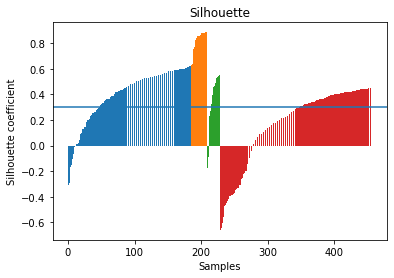

(24, 2)


(24, 4)

In [64]:
# Single
n_clusters = 4
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(proj_df)
cluster = k_means.labels_

# Plot
dat_conn = pd.DataFrame.from_dict({'mrn_csn_pair': dat['mrn_csn_pair'].tolist(),
                                   'cluster': cluster})
dat_conn['cluster'].value_counts()
dat_conn[dat_conn['cluster']==2].to_csv('spectral.csv',index=False)
getSilhouette(cluster)
# getTSplot(n_clusters, cluster)
print(dat_conn[dat_conn['cluster']==1].shape)
pd.merge(dat_conn[dat_conn['cluster']==1], merged, how='inner', on='mrn_csn_pair').shape

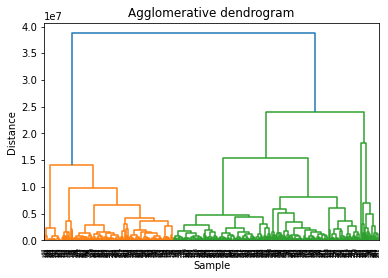

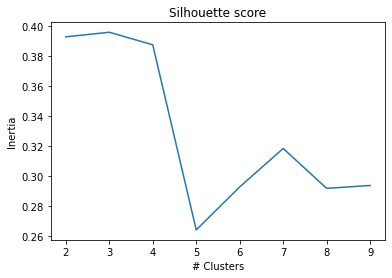

In [72]:
##### Agglomerative Clustering #####
# Get dendrogram
dgram = dendrogram(linkage(dat_n, method='ward'))
plt.title('Agglomerative dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()

ks = range(2, 10)
ss = []
for k in ks:
    ag_cluster = AgglomerativeClustering(n_clusters=k)
    ag_cluster.fit(dat_n)
    cluster = ag_cluster.labels_
    ss.append(silhouette_score(dat_n, ag_cluster.labels_))

plt.plot(ks, ss)
plt.title('Silhouette score')
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.show()

1    138
4    134
0    122
5     24
2     24
6     15
3      1
Name: cluster, dtype: int64


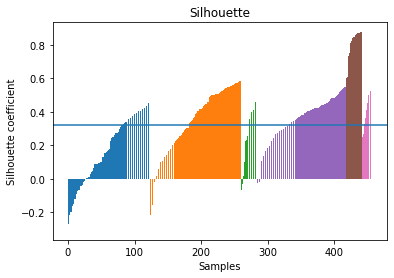

(24, 2)


(24, 4)

In [76]:
# Single
ag_cluster = AgglomerativeClustering(n_clusters=7)
ag_cluster.fit(dat_n)
cluster = ag_cluster.labels_

# Plot
dat_conn = pd.DataFrame.from_dict({'mrn_csn_pair': dat['mrn_csn_pair'].tolist(),
                                   'cluster': cluster})
print(dat_conn['cluster'].value_counts())
dat_conn[dat_conn['cluster']==3].to_csv('agglomerative.csv',index=False)
getSilhouette(cluster)
# getTSplot(n_clusters, cluster)
print(dat_conn[dat_conn['cluster']==5].shape)
pd.merge(dat_conn[dat_conn['cluster']==5], merged, how='inner', on='mrn_csn_pair').shape